In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

### Data Exploration

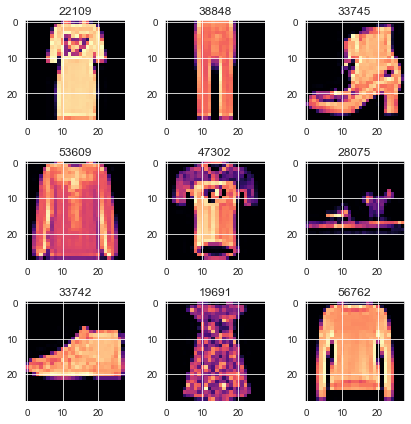

In [164]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#plot sample of random images
figure, axes = plt.subplots(3,3,figsize=(6,6))
axes = axes.reshape(9)
for i,index in enumerate(np.random.randint(0,59999,9)):
    axes[i].imshow(x_train[index], cmap=plt.cm.magma)
    axes[i].set_title(str(index))
    plt.tight_layout()

In [175]:
#data preprocessing
x_train_float = x_train.astype('float32')
x_test_float = x_test.astype('float32')

x_train_float /= 255
x_test_float /= 255

x_train_final = x_train_float.reshape(x_train_float.shape[0], 28, 28, 1)
x_test_final = x_test_float.reshape(x_test_float.shape[0], 28, 28, 1)

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

x_train_sample = x_train_final[0:60000]
y_train_sample = y_train_cat[0:60000]
x_test_sample = x_test_final[0:10000]
y_test_sample = y_test_cat[0:10000]

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

In [177]:
#sequential CNN
model = Sequential([Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=x_train_sample.shape[1:]),
                   Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
                   MaxPool2D(pool_size=(2, 2)),
                   Dropout(rate=0.25),
                   Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
                   Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                   MaxPool2D(pool_size=(2, 2)),
                   Dropout(rate=0.25),
                   Flatten(),
                   Dense(256, activation='relu'),
                   Dropout(rate=0.5),
                   Dense(10, activation='softmax')])

model.summary() 

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

results = model.fit(x_train_sample, y_train_sample, batch_size=100, epochs=5, verbose=1, validation_split=0.2)

# datagen = ImageDataGenerator(rotation_range=10,
#                             zoom_range=0.1,
#                             width_shift_range=0.1,
#                             height_shift_range=0.1)

# epochs = 3
# batch_size = 100
# history = model.fit_generator(datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size), epochs=epochs,
#                              validation_data=(x_test_sample, y_test_sample), steps_per_epoch=x_train_sample.shape[0//batch_size])


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 3, 3, 64)        

In [180]:
#accuracy / loss for train and validation
metrics = pd.DataFrame(results.history)
metrics['epoch'] = [1,2,3,4,5]
metrics

,val_loss,val_accuracy,loss,accuracy,epoch
0,0.505916,0.811417,0.762047,0.712188,1
1,0.386781,0.854917,0.489706,0.820104,2
2,0.330974,0.875417,0.404124,0.851292,3
3,0.315035,0.884667,0.364580,0.866625,4
4,0.298247,0.883833,0.341516,0.876312,5


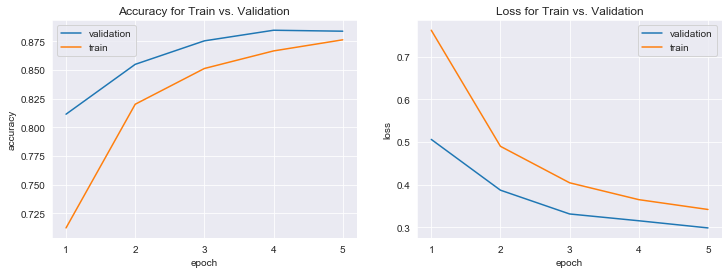

In [181]:
#plot model performance over epochs
fig, axes = plt.subplots(1,2,figsize=(12,4))

sns.lineplot(metrics['epoch'],metrics['val_accuracy'], label='validation',ax=axes[0])
sns.lineplot(metrics['epoch'],y=metrics['accuracy'], label='train',ax=axes[0])
axes[0].set_xticks([1,2,3,4,5])
axes[0].set_title('Accuracy for Train vs. Validation')
axes[0].legend()

sns.lineplot(metrics['epoch'],y=metrics['val_loss'], label='validation', ax=axes[1])
sns.lineplot(metrics['epoch'],y=metrics['loss'], label='train', ax=axes[1])
axes[1].set_xticks([1,2,3,4,5])
axes[1].set_title('Loss for Train vs. Validation')
plt.legend()

In [182]:
#calculate predictions
predictions = new_model.predict(x_test_sample)

counts=Counter()
for x,y in zip(predictions, y_test):
    if np.argmax(x)==y:
        counts[y] +=1
        
counts

Counter({9: 955,
         2: 615,
         1: 930,
         6: 89,
         5: 855,
         7: 887,
         4: 801,
         3: 749,
         8: 920,
         0: 838})

In [216]:
#compare predicted to actuals
pred_labels = [np.argmax(x) for x in predictions]
pred_actual = pd.DataFrame(zip(y_test, pred_labels)).rename(columns={0:'actual', 1:'predicted'})
pred_actual['actual_label'] = pred_actual['actual'].map(categories)
pred_actual['predicted_label'] = pred_actual['predicted'].map(categories)
pred_actual['correct'] = pred_actual['actual'] == pred_actual['predicted']
pred_actual

#pred_actual.groupby('actual_label')['correct'].aggregate({'sum':sum, 'total':len})

,actual,predicted,actual_label,predicted_label,correct
0,9,9,Boot,Boot,True
1,2,2,Pullover,Pullover,True
2,1,1,Trouser,Trouser,True
3,1,1,Trouser,Trouser,True
4,6,2,Shirt,Pullover,False
...,...,...,...,...,...
9995,9,9,Boot,Boot,True
9996,1,1,Trouser,Trouser,True
9997,8,8,Bag,Bag,True
9998,1,1,Trouser,Trouser,True


In [208]:
#closer look at shirts, most incorrectly predicted label
incorrect = pred_actual[pred_actual['actual_label']=='Shirt']
incorrect

,actual,predicted,actual_label,predicted_label,correct
4,6,2,Shirt,Pullover,False
7,6,6,Shirt,Shirt,True
26,6,4,Shirt,Coat,False
40,6,0,Shirt,T-shirt/top,False
44,6,4,Shirt,Coat,False
...,...,...,...,...,...
9962,6,2,Shirt,Pullover,False
9971,6,6,Shirt,Shirt,True
9977,6,0,Shirt,T-shirt/top,False
9979,6,0,Shirt,T-shirt/top,False


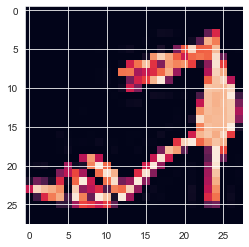

In [214]:
#this is apparently a shirt? lol something wrong w the indices
plt.imshow(x_train[9962])

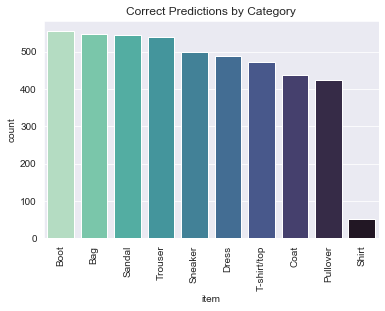

In [135]:
#plot frequency of accurate predictions by category
predicted = pd.DataFrame.from_dict(counts, orient='index').reset_index().rename(columns={'index':'label', 0:'count'})
predicted['item'] = predicted['label'].map(categories)
predicted = predicted.sort_values('count', ascending=False)
sns.barplot(predicted['item'], predicted['count'], palette='mako_r')
plt.title('Correct Predictions by Category')
ticks=plt.xticks(rotation='vertical')

In [130]:
#save and load a model
model.save('mnist_fashion.model')
new_model = tf.keras.models.load_model('mnist_fashion.model')

In [38]:
# model = Sequential([
#     Dense(16, input_shape=x_train_sample.shape[1:]),
#     Dense(32, activation='relu'),
#     Dense(10, activation='softmax', input_shape=x_train_sample.shape[1:]),
# ])

# model.summary()

# model.compile(Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.fit(x_train_sample, y_train_sample, batch_size=100, epochs=3, verbose=2)